# Creating a Machine Leaning Potential (MLP)

This note book will walk through creating a simple MLP from scratch. For simplicity it will be fitted to a 2D Lennard Jones system

## Making a descriptor

Feeding Atomic coordinates directly into a neural network (NN) is not going to work very well. We need to make a description of the local atomic environment that is *invariant* (more sophisticated models are also *equivariant*)

Invariant means that If the atomic configuration is rotated or displaced then the energy will be the same. MM forcefields are invariant. 

An invariant description of an atomic configuration can be built by considering the relative distances between the atoms. A NN takes a finite set of inputs, for our models to work with different number of neighbor atoms then the descriptors needs to be independent of the number of neighbors. To do this we project the local neighborhood density of an atom onto a radial basis.

Mathematically we can write this as 

$ B_{in} = \sum_j  R(r_{ij})_n $

$B_{in}$ is a 2D tensor of size $(N_{atoms}, N_{basis functions})$. The $i$ index corresponds to each atom. The $n$ index corresponds to the radial basis. 
$R(r)_n$ is a function that takes a distance $r$ and maps it onto a 1D Tensor of size $(N_{basis functions})$.
The sum is over all $j$ neighbors of atom $i$.
i.e. each row $i$ of the tensor $B$ contains the description of atom $i$ local environment encoded into the radial basis.

There are different options available, one of the simplest is Gaussian functions.

$R(r)_n = exp(-(r - e_n)^2/w)f(r) $

$e_n$ is a set of values e.g. $[e_0,e_1 .. , r_{cutoff}]$, $f(r)$ is an envelope function that is zero at $r_{cutoff}$ and makes the derivative at $r_{cutoff}$ continuous. 


An example is shown in the code below.

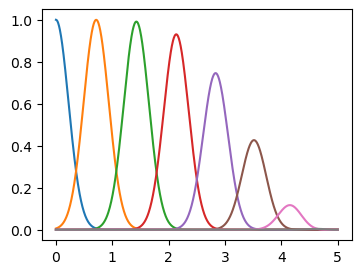

In [1]:
import torch
import matplotlib.pyplot as plt 

N = 8
w = 0.1
r_cutoff = 5.0

def f(x):
    return( 1 - 28*x**6 + 48*x**7 - 21*x**8 )

xx=torch.linspace(0, r_cutoff, 1000)
en = torch.linspace(0,r_cutoff, N)

plt.figure(figsize=(4,3))
for e in en:
    y = torch.exp(-(xx-e)**2/w)*f(xx/r_cutoff)
    plt.plot(xx,y)

plt.show()

# Projecting the atomic neighbors onto the radial basis

Lets generate some random coordinates, and get the radial basis descriptor for one of the atoms

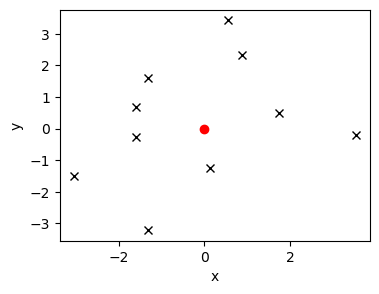

B0n: tensor([4.7416e-11, 1.0550e-03, 8.6900e-01, 1.1383e-01, 1.1556e+00, 2.1521e-01,
        6.5883e-02, 1.2401e-03])


In [2]:
import numpy as np
N=10

torch.manual_seed(1)
x=torch.randn(10,2)*2

def envelope(x):
    return( 1 - 28*x**6 + 48*x**7 - 21*x**8 )

def radial_basis(r,en, w, r_cutoff):
    f=envelope(r/r_cutoff)
    Bjn = torch.exp(-(r[:,None] - en[None,:])**2/w)*f[:,None]
    Bn = torch.sum(Bjn, dim=0)
    return Bn

# make a central atom at (0,0) and compute the distances
xi = torch.tensor([[0,0]])
d = xi-x
r = torch.sum(d**2, dim=1)

# plot the coords
plt.figure(figsize=(4,3))
plt.plot(x[:,0], x[:,1],'kx')
plt.plot(xi[0,0], xi[0,1],'ro')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

N = 8
w = 0.1
r_cutoff = 5.0
en = torch.linspace(0,r_cutoff, N)
Bin = radial_basis(r,en,w,r_cutoff)

# Print the radial basis tensor for atom i=0
print("B0n:", Bin)


We can plot what this descriptor means, i.e. what the atoms sees:

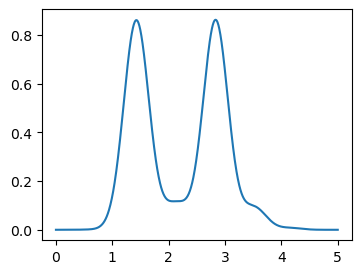

In [3]:

plt.figure(figsize=(4,3))
xx=torch.linspace(0, r_cutoff, 1000)
ys=[]
for n,e in enumerate(en):
    y = Bin[n]*torch.exp(-(xx-e)**2/w)*envelope(xx/r_cutoff)
    y=y.numpy()
    ys.append(y)
    
ys=np.sum(np.array(ys),axis=0)
plt.plot(xx,ys)
plt.show()


## Making a Neural Network

We can use a very basic standard neural network example.

there are two hidden layers which each have 16 features, and one output layer. The only thing we need to be careful about is that our activation functions should have smooth derivatives so we use SiLU instead of the common ReLU


In [4]:
class NNP(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # in the constructor we define the structure of the NN
        self.NN = torch.nn.Sequential(
            torch.nn.Linear(N, 16),
            torch.nn.SiLU(),
            torch.nn.Linear(16, 16),
            torch.nn.SiLU(),
            torch.nn.Linear(16, 1),
        )

    def forward(self, B):
        
        # in the forward method we tell the NNP what to do when data is passed into it
        E = self.NN(B)

        return E
    
model = NNP()
print(model)

NNP(
  (NN): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): SiLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): SiLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


We can now run our descriptor through the NNP. The model weights are randomly initialised so this will give us some output

In [5]:
prediction = model(Bin)
print(prediction)

tensor([-0.0081], grad_fn=<AddBackward0>)


Now lets compute the actual energy for this atomic configuration

In [6]:
def energy(r):
    sigma=1.0
    epsilon=2.0
    c6 = (sigma**2 / r**2)**3
    c12 = c6**2
    return torch.sum(4 * epsilon * (c12 - c6))


E = energy(r)
print(E)

tensor(-0.5960)


Now we can define the loss function and run a loop to minimize it

loss =  0.34567755460739136
loss =  0.3266482353210449
loss =  0.30868643522262573
loss =  0.29172852635383606
loss =  0.2757151126861572
loss =  0.2605908513069153
loss =  0.24630394577980042
loss =  0.23280611634254456
loss =  0.22005212306976318
loss =  0.20799952745437622


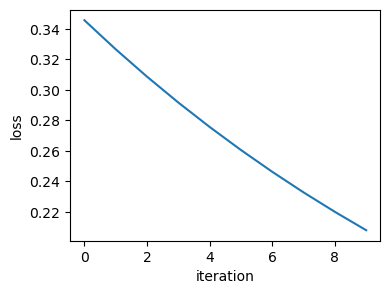

In [7]:
losses=[]
for i in range(10):
    prediction = model(Bin) 

    loss = (prediction-E)**2

    print("loss = ", loss.item())
    # To minimize the loss we compute the gradient of the loss with respect to the model parameters and take a step in that direction

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= 0.01 * param.grad

    losses.append(loss.detach().numpy())

plt.figure(figsize=(4,3))
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.show()


Of course this is just one atomic configuration so it is not learning anything that is useful or transferable. 
To properly train a MLP we will use a more complex script that reads in some atomic configurations we have already generated.

## Dataset generation

We will generate a dataset of the LJ fluid using the script `generate.py`

In [8]:
!python generate.py

0 / 100000 Energy = -28.709701538085938
10000 / 100000 Energy = -240.95594787597656
20000 / 100000 Energy = -290.2216796875
30000 / 100000 Energy = -290.20941162109375
40000 / 100000 Energy = -289.05474853515625
50000 / 100000 Energy = -293.42535400390625
60000 / 100000 Energy = -286.477294921875
70000 / 100000 Energy = -219.0528564453125
80000 / 100000 Energy = -269.2528076171875
90000 / 100000 Energy = -334.5185241699219


## Training a MLP

The MLP we will use is in `train_mlp.py`

Take a look at the script before we run it

The NN looks like this:
```python
class NNP(torch.nn.Module):
    def __init__(self, NB, rb, w, RCUT):
        super().__init__()
        self.NB = NB # num basis functions
        self.NF1 = NF1 # num features of hidden layer 1
        self.NF2 = NF2 # num features of hidden layer 2
        self.rb = rb   # vector of the location of the Gaussian basis functions
        self.w  = w    # width of the Gaussian basis functions
        self.RCUT = RCUT # cut off distance

        self.NN = torch.nn.Sequential(
            torch.nn.Linear(self.NB, self.NF1, dtype=torch.get_default_dtype()),
            torch.nn.SiLU(),
            torch.nn.Linear(self.NF1, self.NF2, dtype=torch.get_default_dtype()),
            torch.nn.SiLU(),
            torch.nn.Linear(self.NF2, 1, dtype=torch.get_default_dtype()),
        )

    def forward(self, x):

        # x is batched coordinates
        # the shape of x is [N_batch, N_atoms, 2]

        # turn into radial basis features
        descriptor = make_descriptor(x, self.rb, self.w, self.RCUT)

        # the shape of descriptor is [N_batch, N_atoms, N_basis]

        # pass the descriptor through the NN
        Es = self.NN(descriptor)

        # the shape of Es is [N_batch, N_atom]
   
        # total energy is the sum of the energy of each atom
        total_E = torch.sum(Es.squeeze(dim=-1), dim=-1)

        # the shape of total_E is [N_batch]

        return total_E

```

For the model in `train_mlp.py` there are 16 radial basis functions and two hidden layers each with 64 features.
We use a batch size of 10 and run for 100 epochs

In [9]:
!python train_mlp.py

NNP(
  (NN): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoc  0 training loss:  661.2177734375 , validation loss: 1492.74072265625 validation error: 29.485013961791992
Epoc  10 training loss:  499.0157165527344 , validation loss: 373.05242919921875 validation error: 14.28175163269043
Epoc  20 training loss:  184.88673400878906 , validation loss: 246.59112548828125 validation error: 10.533097267150879
Epoc  30 training loss:  235.92276000976562 , validation loss: 487.41351318359375 validation error: 18.820049285888672
Epoc  40 training loss:  46.3516845703125 , validation loss: 131.02072143554688 validation error: 6.285459518432617
Epoc  50 training loss:  18.92575454711914 , validation loss: 98.93163299560547 validation error: 5.779119968414307
Epoc  60 training loss:  488.9835510253906 , validation los

## Using the MLP

The script `md_with_mlp.py` will run the simulation using the model as the potential energy function

In [10]:
!python md_with_mlp.py

0 / 10000 Energy = -29.548952102661133
1000 / 10000 Energy = -214.49386596679688
2000 / 10000 Energy = -253.12379455566406
3000 / 10000 Energy = -249.751220703125
4000 / 10000 Energy = -234.92198181152344
5000 / 10000 Energy = -293.5754089355469
6000 / 10000 Energy = -257.02532958984375
7000 / 10000 Energy = -251.6908416748047
8000 / 10000 Energy = -269.70611572265625
9000 / 10000 Energy = -255.85220336914062


## Checking the MLP

We can check the MLP works by look at the trajectory, the script below (same as `compare_trajs.py`) will plot the pair distributions functions of the reference dataset and the MLP trajectory

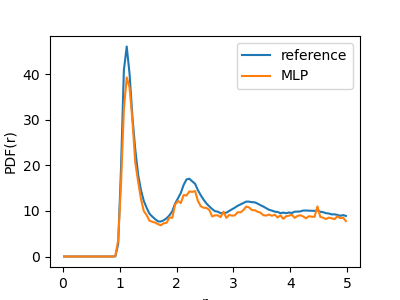

In [11]:
!python compare_trajs.py

from IPython.display import Image
Image("comparison.png")